In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""

import sys
sys.path.append('../../lib')
from tqdm import tqdm
from scipy.signal import fftconvolve
import numpy as np
import os
import matplotlib.pyplot as plt
from fast_detection_methods import trajectory_gauss, trajectory_mean, trajectory_corr
from movie_processing import movie_to_array, clean_problem_pixels
from Powerspectra import powerspectrum, fit_power_spectrum, plot_power_spectra, fast_analytical_noisy_powerspectrum
#from pipython.datarectools import getservotime
import cv2
import Powerspectra
from SpectralMechanicsAnalysis import Data, mean_back_realxation, mean_back_relaxation_multiple_trajectories, mean_back_relaxation_multiple_trajectories_with_timestamps, mean_back_relaxation_multiple_trajectories_with_timestamps
from Powerspectra import bin_data
#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

In [3]:
def select_file(khz_value, files):
    for file in files:
        if f"{khz_value}_khz" in file:
            return file
    return None

In [4]:
data_path = r'\\134.76.13.158\betzlab\Julian\Hydrogel\measurement_2'

file_list =[ file for file in  os.listdir(data_path) if file.endswith('.avi')]
print(file_list)

['10_khz_Export_20231006_112401.avi', '1_khz_Export_20231006_104624.avi', '25_khz_Export_20231006_140921.avi', '50_khz_Export_20231006_121201.avi', '5_khz_Export_20231006_105529.avi']


In [5]:
f_list = [1,5,10,25]
data_list = []
for f in f_list:
    f_data_path = os.path.join(data_path, f'{f}_khz')
    x_data = np.load(os.path.join(f_data_path,r"corr\x_trajecories.npy"))
    y_data = np.load(os.path.join(f_data_path,r"corr\y_trajecories.npy"))
    t_data = np.linspace(0, len(x_data)/(1000*f), len(x_data))

    data_list.append(Data(t_data, x_data, typical_peak_number=1, max_peak_percentage=.9, log_weighted=True, unweighted_postfit = True))
    data_list.append(Data(t_data, y_data, typical_peak_number=1, max_peak_percentage=.9, log_weighted=True, unweighted_postfit = True))


In [6]:
for data in data_list:
    data.bayesian_update()

In [7]:
for data in data_list:
    data.peaks = []
    data.max_peak_percentage = 0.8
    data.find_peaks(max_iter=5)

In [8]:
for data in data_list:
    data.create_reconstructed_data()

In [11]:
len(f_list)


4

In [12]:
len(data_list)

8

In [45]:

def mean_back_realxation(dt, trajectory, Tao, timespan, multiplier=1, d_sigma_estimation_samples = 1000, return_n_points_added=False, progress_bar = True, min_cutoff = 0):
    if isinstance(trajectory, list):
        trajectory = np.array(trajectory, dtype=np.float64)  # Ensure high precision
    forward_sampling = int(timespan / dt)
    backward_sampling = int(Tao / dt)

    d_array = trajectory[backward_sampling:] - trajectory[:-backward_sampling]

    # Estimate the standard deviation of the d array
    d_sample = np.random.choice(d_array, size=min(d_sigma_estimation_samples, len(d_array)), replace=False)
    d_sigma = np.std(d_sample)
    d_cutoff = d_sigma * multiplier

    if d_cutoff < min_cutoff:
        print(f"Warning: d_cutoff is smaller than min_cutoff. Setting d_cutoff {d_cutoff} = min_cutoff {min_cutoff}")
        d_cutoff = min_cutoff
    else:
        print(f"d_cutoff: {d_cutoff}, min_cutoff: {min_cutoff}")    

    valid_points = np.abs(d_array) > d_cutoff
    valid_indices = np.where(valid_points[:-forward_sampling])[0]

    # Initialize an accumulator for the samples with high precision
    sample_accumulator = np.zeros(forward_sampling, dtype=np.float64)

    n_points_added = 0

    # Iterate over the valid indices and accumulate the samples. make a progress bar if progress_bar is True
    for idx in tqdm(valid_indices, disable=not progress_bar, total=len(valid_indices)):
        sample = trajectory[idx + backward_sampling : idx + backward_sampling + forward_sampling] - trajectory[idx + backward_sampling]
        d_mbr = d_array[idx]
        sample_to_add = (-sample / d_mbr).astype(np.float64)  # Ensure high precision
        
        # Accumulate the samples directly
        sample_accumulator += sample_to_add
        n_points_added += 1

    # Normalize the accumulated samples by the total number of points added
    if n_points_added > 0:  # Avoid division by zero
        mbr_trajectory = sample_accumulator / n_points_added
    else:
        # Handle case with no valid points added
        mbr_trajectory = np.zeros(forward_sampling, dtype=np.float64)  # or an appropriate default/fallback value

    if return_n_points_added:
        return mbr_trajectory, n_points_added
    else:
        return mbr_trajectory

In [46]:
nm_pro_pixel = 0.036768956332537246 * 1000

error = 10 / (nm_pro_pixel )

In [47]:

for data in data_list:
    end_PSD = np.mean(data.PSD[-100:])
    error = np.sqrt(end_PSD * nm_pro_pixel**2)
    print(f"Error: {error}")

    error_in_pixels = error / nm_pro_pixel
    print(f"Error in pixels: {error_in_pixels}")

    print(f"Error in pixels: {np.sqrt(end_PSD)}")
    #assert error_in_pixels == np.sqrt(end_PSD)

    data.error_in_pixels = error_in_pixels

Error: 0.7627179788355634
Error in pixels: 0.02074353081815994
Error in pixels: 0.02074353081815994
Error: 1.0164697399611697
Error in pixels: 0.02764478085176665
Error in pixels: 0.027644780851766654
Error: 1.0523364302409597
Error in pixels: 0.02862024205211764
Error in pixels: 0.028620242052117644
Error: 1.284753261443628
Error in pixels: 0.034941249075017555
Error in pixels: 0.034941249075017555
Error: 0.6900635633827746
Error in pixels: 0.018767559164363064
Error in pixels: 0.018767559164363064
Error: 0.781422028869081
Error in pixels: 0.02125222216812263
Error in pixels: 0.021252222168122628
Error: 1.0544155548971914
Error in pixels: 0.028676787705397222
Error in pixels: 0.028676787705397222
Error: 1.283862131903165
Error in pixels: 0.03491701315348626
Error in pixels: 0.03491701315348626


In [48]:
error

1.283862131903165

In [49]:
dt = [[1/(1000*f), 1/(1000*f)] for f in f_list]
dt = np.array(dt).flatten()

T = .5
tau_multiplyer_list = np.array([1,2,5,10,20,50,100])
mbr_list = [[] for _ in data_list]
mbr_longtime_list = [[] for _ in data_list]
tau_meta_list = [[] for _ in data_list]
t_mbr_list = []
for i, (data, dt) in enumerate(zip(data_list, dt)):
    tau_list = tau_multiplyer_list*dt
    for j, tau in enumerate(tau_list):

        error_in_pixels = np.sqrt(np.mean(data.PSD[-100:]))
        mbr = mean_back_realxation(dt,data.reconstructed_x, tau, T, min_cutoff = error_in_pixels)
        mbr_list[i].append(mbr)
        
        second_half_mbr = mbr[int(len(mbr)/2):]
        mean_second_half_mbr = np.mean(second_half_mbr)
        std_second_half_mbr = np.std(second_half_mbr)
        mbr_longtime_list[i].append((mean_second_half_mbr, std_second_half_mbr))

        tau_meta_list[i].append(tau)
    t_mbr_list.append(np.linspace(0, len(mbr)*dt, len(mbr)))

d_cutoff: 0.04573088593915136, min_cutoff: 0.02074353081815994


100%|██████████| 23556/23556 [00:00<00:00, 262365.37it/s]


d_cutoff: 0.06309472127760803, min_cutoff: 0.02074353081815994


100%|██████████| 23463/23463 [00:00<00:00, 281729.57it/s]


d_cutoff: 0.08200498111214409, min_cutoff: 0.02074353081815994


100%|██████████| 23836/23836 [00:00<00:00, 287494.73it/s]


d_cutoff: 0.09702965134440661, min_cutoff: 0.02074353081815994


100%|██████████| 24520/24520 [00:00<00:00, 211561.62it/s]


d_cutoff: 0.11811085672270452, min_cutoff: 0.02074353081815994


100%|██████████| 22574/22574 [00:00<00:00, 271557.20it/s]


d_cutoff: 0.13066548384452806, min_cutoff: 0.02074353081815994


100%|██████████| 24373/24373 [00:00<00:00, 243821.50it/s]


d_cutoff: 0.14579112000566694, min_cutoff: 0.02074353081815994


100%|██████████| 24249/24249 [00:00<00:00, 299064.58it/s]


d_cutoff: 0.0472235358321119, min_cutoff: 0.027644780851766654


100%|██████████| 24879/24879 [00:00<00:00, 266210.07it/s]


d_cutoff: 0.07159104416083914, min_cutoff: 0.027644780851766654


100%|██████████| 21709/21709 [00:00<00:00, 241357.76it/s]


d_cutoff: 0.09162077429013896, min_cutoff: 0.027644780851766654


100%|██████████| 23437/23437 [00:00<00:00, 281068.16it/s]


d_cutoff: 0.10328344175202393, min_cutoff: 0.027644780851766654


100%|██████████| 24656/24656 [00:00<00:00, 296123.06it/s]


d_cutoff: 0.11903771732187604, min_cutoff: 0.027644780851766654


100%|██████████| 24333/24333 [00:00<00:00, 290878.62it/s]


d_cutoff: 0.14401781222437213, min_cutoff: 0.027644780851766654


100%|██████████| 23224/23224 [00:00<00:00, 249067.40it/s]


d_cutoff: 0.15837990456665932, min_cutoff: 0.027644780851766654


100%|██████████| 23760/23760 [00:00<00:00, 222420.11it/s]


d_cutoff: 0.043973228327868916, min_cutoff: 0.028620242052117644


100%|██████████| 32362/32362 [00:00<00:00, 161367.71it/s]


d_cutoff: 0.050527797322070134, min_cutoff: 0.028620242052117644


100%|██████████| 29183/29183 [00:00<00:00, 131538.51it/s]


d_cutoff: 0.0555993096870931, min_cutoff: 0.028620242052117644


100%|██████████| 30457/30457 [00:00<00:00, 171049.03it/s]


d_cutoff: 0.059837249699307656, min_cutoff: 0.028620242052117644


100%|██████████| 31959/31959 [00:00<00:00, 161967.50it/s]


d_cutoff: 0.06983833358828007, min_cutoff: 0.028620242052117644


100%|██████████| 30420/30420 [00:00<00:00, 159852.87it/s]


d_cutoff: 0.08323731726038161, min_cutoff: 0.028620242052117644


100%|██████████| 31000/31000 [00:00<00:00, 153254.51it/s]


d_cutoff: 0.09600829204773349, min_cutoff: 0.028620242052117644


100%|██████████| 30055/30055 [00:00<00:00, 141382.09it/s]


d_cutoff: 0.05106253655339029, min_cutoff: 0.034941249075017555


100%|██████████| 29821/29821 [00:00<00:00, 157932.38it/s]


d_cutoff: 0.05196752838987335, min_cutoff: 0.034941249075017555


100%|██████████| 32048/32048 [00:00<00:00, 152503.01it/s]


d_cutoff: 0.05806538509567483, min_cutoff: 0.034941249075017555


100%|██████████| 31651/31651 [00:00<00:00, 154942.09it/s]


d_cutoff: 0.06807041131954307, min_cutoff: 0.034941249075017555


100%|██████████| 29017/29017 [00:00<00:00, 160551.57it/s]


d_cutoff: 0.0737999709472468, min_cutoff: 0.034941249075017555


100%|██████████| 30774/30774 [00:00<00:00, 151979.42it/s]


d_cutoff: 0.08756034233382716, min_cutoff: 0.034941249075017555


100%|██████████| 31222/31222 [00:00<00:00, 158011.50it/s]


d_cutoff: 0.10401834539587433, min_cutoff: 0.034941249075017555


100%|██████████| 29374/29374 [00:00<00:00, 136255.09it/s]


d_cutoff: 0.033550766660309775, min_cutoff: 0.018767559164363064


100%|██████████| 28951/28951 [00:00<00:00, 110285.50it/s]


d_cutoff: 0.03959428330007658, min_cutoff: 0.018767559164363064


100%|██████████| 30832/30832 [00:00<00:00, 108830.47it/s]


d_cutoff: 0.05231270927465865, min_cutoff: 0.018767559164363064


100%|██████████| 30300/30300 [00:00<00:00, 107161.66it/s]


d_cutoff: 0.06188697458271005, min_cutoff: 0.018767559164363064


100%|██████████| 30955/30955 [00:00<00:00, 109405.87it/s]


d_cutoff: 0.07577452980024475, min_cutoff: 0.018767559164363064


100%|██████████| 30524/30524 [00:00<00:00, 103706.43it/s]


d_cutoff: 0.09135611203115926, min_cutoff: 0.018767559164363064


100%|██████████| 31123/31123 [00:00<00:00, 113420.34it/s]


d_cutoff: 0.10563756838032412, min_cutoff: 0.018767559164363064


100%|██████████| 30496/30496 [00:00<00:00, 113968.12it/s]


d_cutoff: 0.035314347965774893, min_cutoff: 0.021252222168122628


100%|██████████| 29993/29993 [00:00<00:00, 111834.24it/s]


d_cutoff: 0.042853668464902434, min_cutoff: 0.021252222168122628


100%|██████████| 29767/29767 [00:00<00:00, 105402.10it/s]


d_cutoff: 0.054176434065317636, min_cutoff: 0.021252222168122628


100%|██████████| 29966/29966 [00:00<00:00, 111879.07it/s]


d_cutoff: 0.06239193633651267, min_cutoff: 0.021252222168122628


100%|██████████| 31654/31654 [00:00<00:00, 114293.87it/s]


d_cutoff: 0.07820962619533298, min_cutoff: 0.021252222168122628


100%|██████████| 29826/29826 [00:00<00:00, 90763.29it/s]


d_cutoff: 0.09886327831923901, min_cutoff: 0.021252222168122628


100%|██████████| 28413/28413 [00:00<00:00, 111415.98it/s]


d_cutoff: 0.11112279722172108, min_cutoff: 0.021252222168122628


100%|██████████| 29423/29423 [00:00<00:00, 110578.18it/s]


d_cutoff: 0.04332911098025085, min_cutoff: 0.028676787705397222


100%|██████████| 29574/29574 [00:00<00:00, 60027.65it/s]


d_cutoff: 0.04947646593048016, min_cutoff: 0.028676787705397222


100%|██████████| 27089/27089 [00:00<00:00, 60375.91it/s]


d_cutoff: 0.052497671783681664, min_cutoff: 0.028676787705397222


100%|██████████| 29805/29805 [00:00<00:00, 60670.43it/s]


d_cutoff: 0.06228770843895517, min_cutoff: 0.028676787705397222


100%|██████████| 26989/26989 [00:00<00:00, 58939.31it/s]


d_cutoff: 0.06995087293635899, min_cutoff: 0.028676787705397222


100%|██████████| 27229/27229 [00:00<00:00, 58276.61it/s]


d_cutoff: 0.08136724491984881, min_cutoff: 0.028676787705397222


100%|██████████| 28613/28613 [00:00<00:00, 60044.42it/s]


d_cutoff: 0.0952878288541711, min_cutoff: 0.028676787705397222


100%|██████████| 27357/27357 [00:00<00:00, 51433.34it/s]


d_cutoff: 0.05035992912642857, min_cutoff: 0.03491701315348626


100%|██████████| 27216/27216 [00:00<00:00, 54369.03it/s]


d_cutoff: 0.05195156605166132, min_cutoff: 0.03491701315348626


100%|██████████| 28597/28597 [00:00<00:00, 59048.44it/s]


d_cutoff: 0.05799934636114536, min_cutoff: 0.03491701315348626


100%|██████████| 28317/28317 [00:00<00:00, 56486.02it/s]


d_cutoff: 0.06635339783976636, min_cutoff: 0.03491701315348626


100%|██████████| 27037/27037 [00:00<00:00, 55482.42it/s]


d_cutoff: 0.07388166745920265, min_cutoff: 0.03491701315348626


100%|██████████| 27458/27458 [00:00<00:00, 57721.67it/s]


d_cutoff: 0.08799463922427582, min_cutoff: 0.03491701315348626


100%|██████████| 27866/27866 [00:00<00:00, 55906.00it/s]


d_cutoff: 0.10182140985203114, min_cutoff: 0.03491701315348626


100%|██████████| 27473/27473 [00:00<00:00, 54714.17it/s]


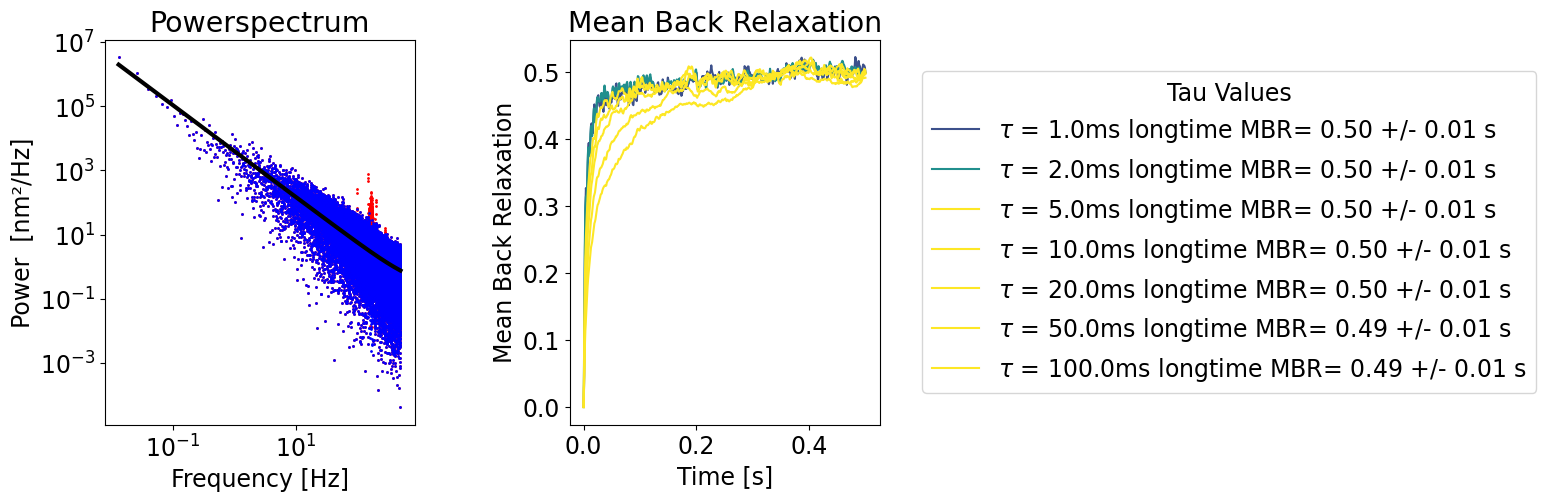

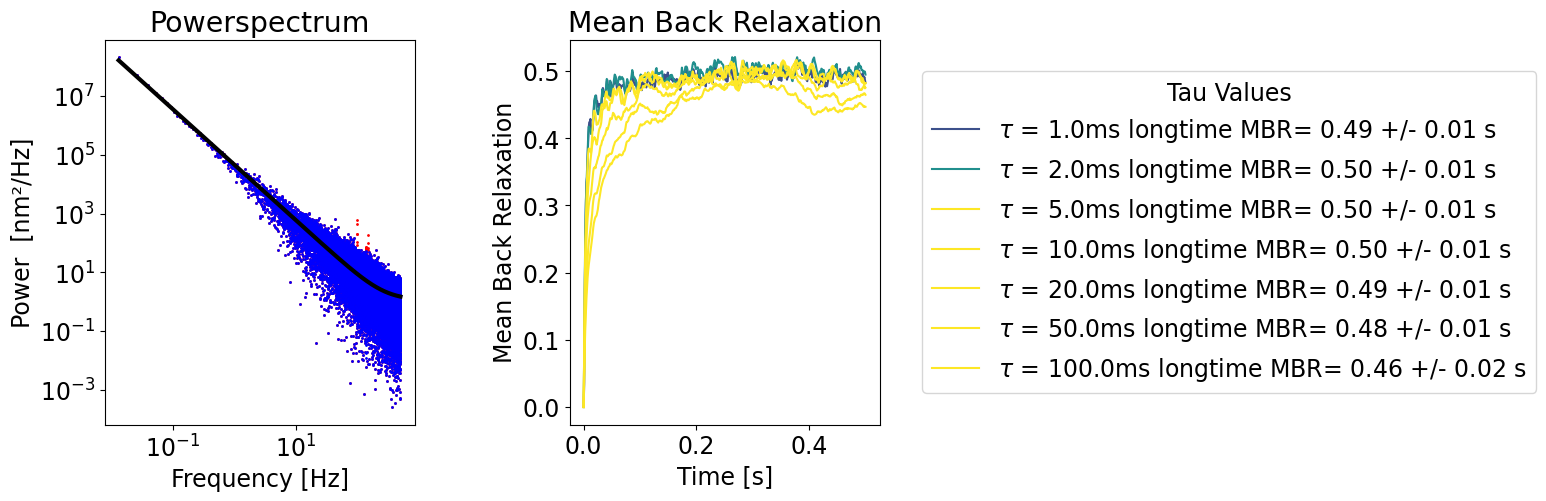

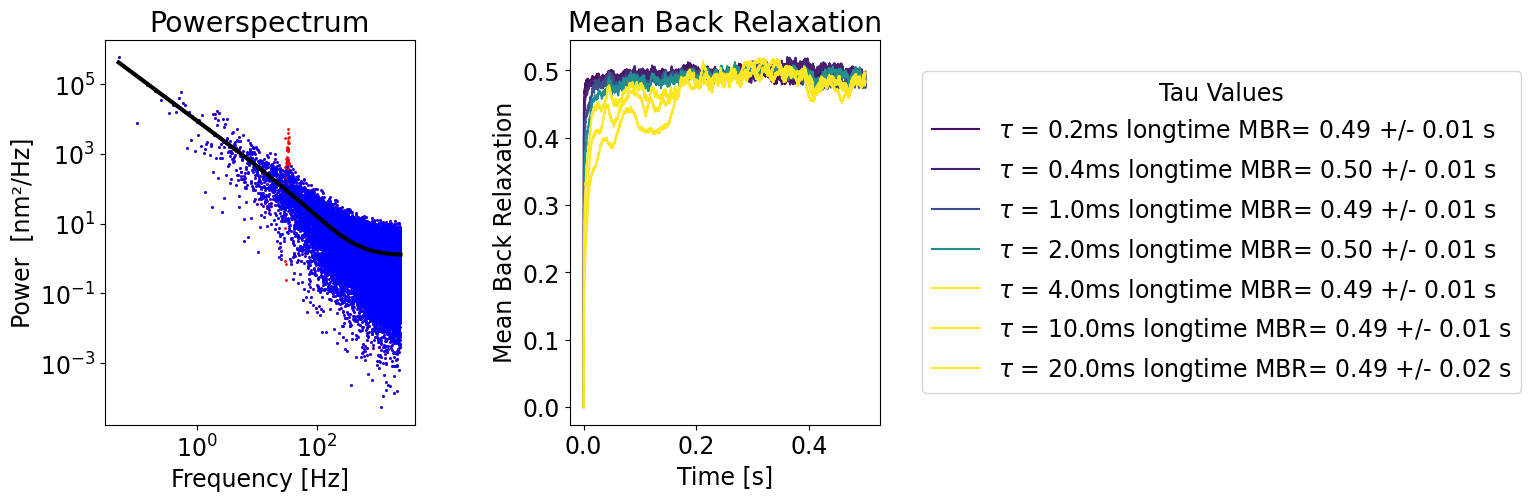

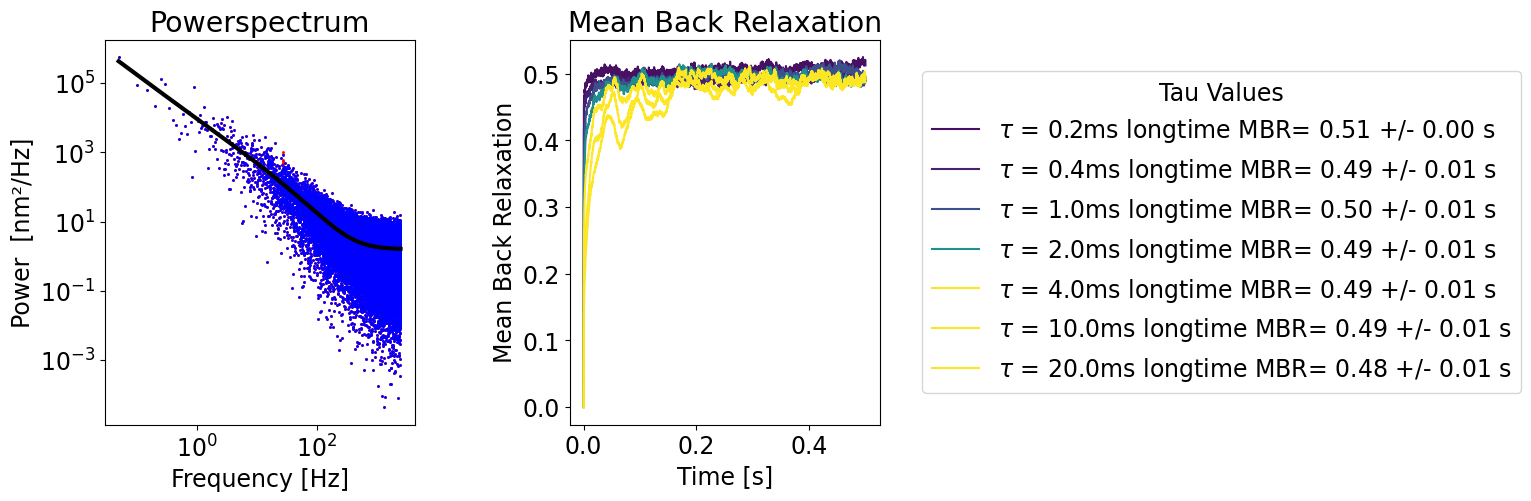

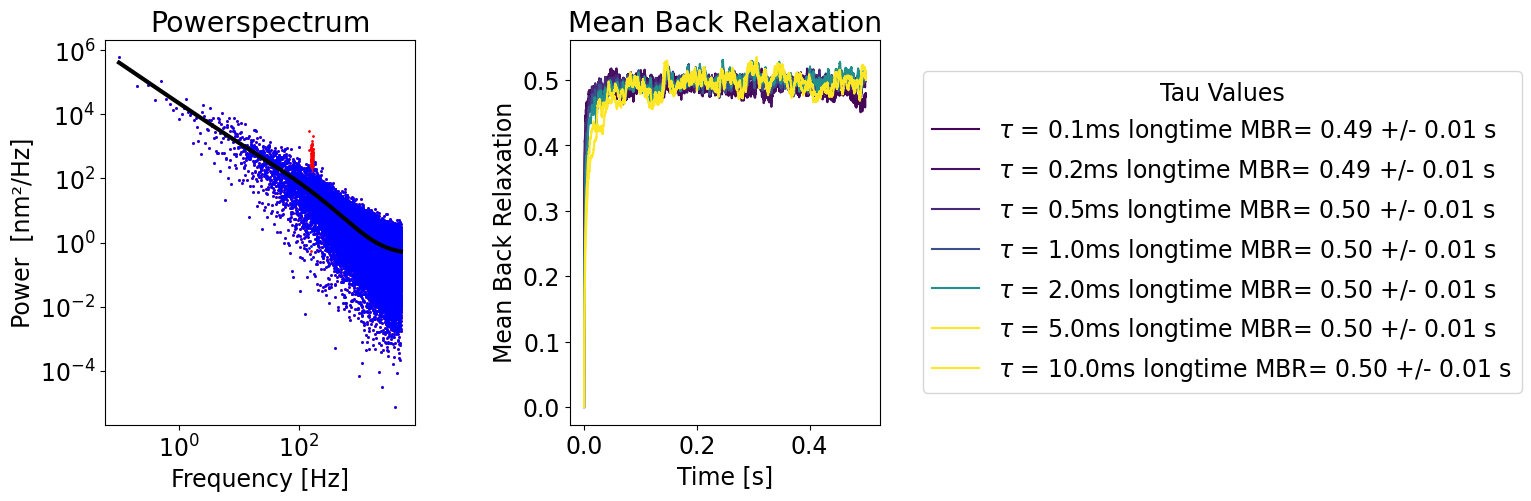

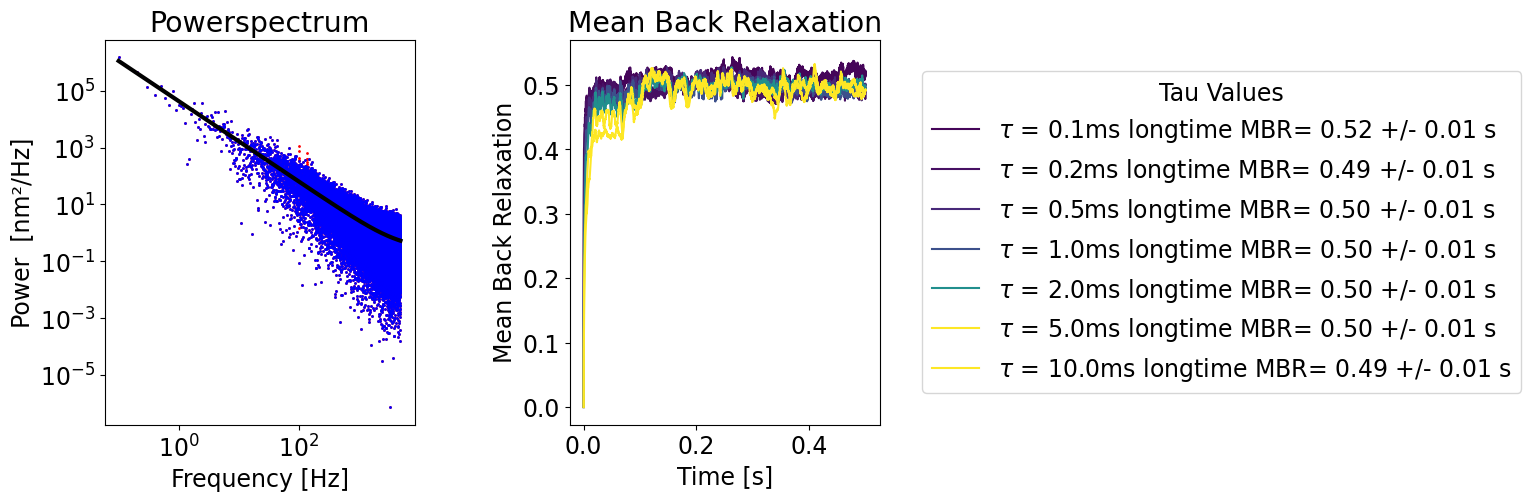

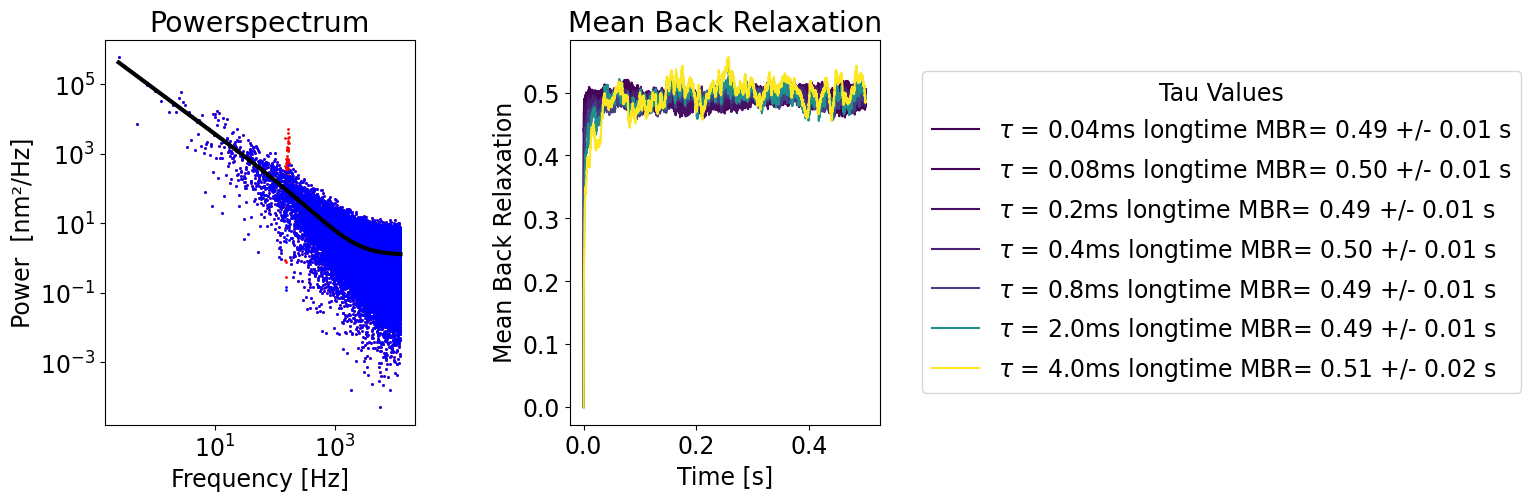

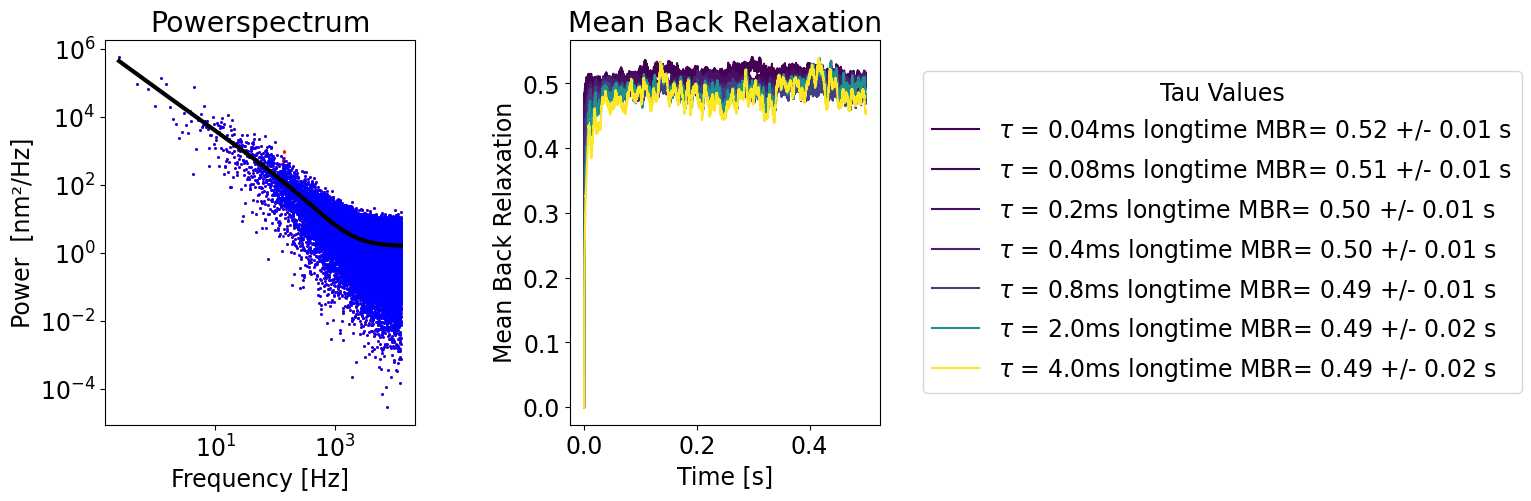

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming tau_list, t_mbr, and other necessary data are defined
nm_pro_pixel = (0.036768956332537246 * 1000)**2
# Creating a colormap
cmap = plt.cm.viridis  # You can choose any available colormap
norm = plt.Normalize(min(tau_list), max(tau_list))

for data, mbr_selection, longtime_mbr_selection, tau_list, t_mbr in zip(data_list, mbr_list, mbr_longtime_list, tau_meta_list, t_mbr_list):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # First subplot for PSD
    ax[0].scatter(data.frequencies, data.PSD*nm_pro_pixel, color='red', s=1)
    ax[0].scatter(data.frequencies, data.reconstructed_PSD*nm_pro_pixel, color='blue', s=1)
    ax[0].plot(data.frequencies, data.fit_function(data.frequencies, data.fit_params)*nm_pro_pixel, color='black', linewidth=3)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title('Powerspectrum')
    ax[0].set_xlabel('Frequency [Hz]')
    ax[0].set_ylabel('Power  [nm²/Hz]')

    # Second subplot for Mean Back Relaxation
    for tau, mbr, longtime_mbr in zip(tau_list, mbr_selection, longtime_mbr_selection):
        # Assign a color from the colormap based on tau value
        color = cmap(norm(tau))
        ax[1].plot(t_mbr, mbr, color=color, label=f'$\\tau$ = {tau*1000}ms longtime MBR= {longtime_mbr[0]:.2f} +/- {longtime_mbr[1]:.2f} s')

    ax[1].set_title('Mean Back Relaxation')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Mean Back Relaxation')

    # Placing the legend outside the plot on the left side
    ax[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), title="Tau Values")

    # Adjust spacing between the plots
    plt.subplots_adjust(wspace=0.5)

    plt.show()

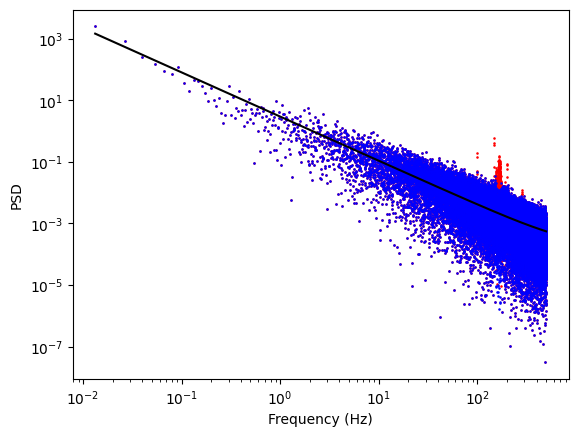

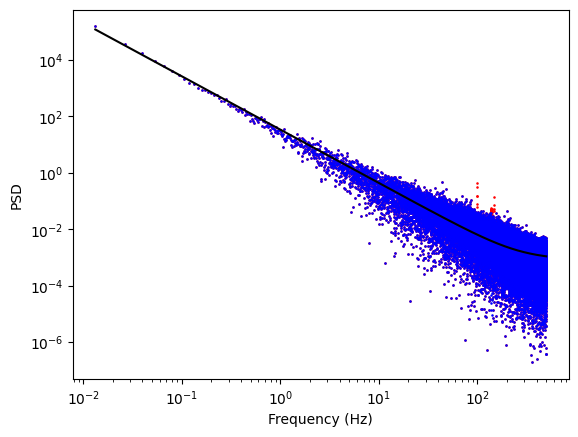

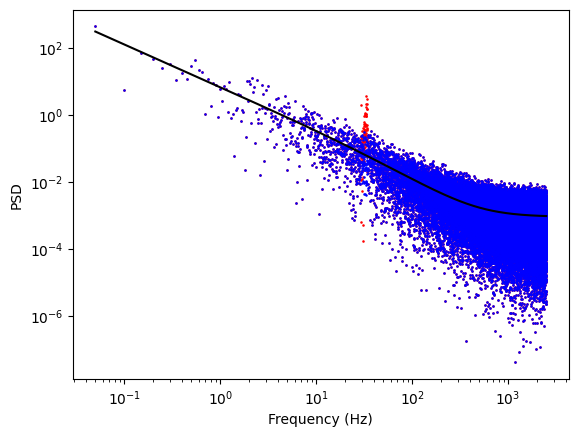

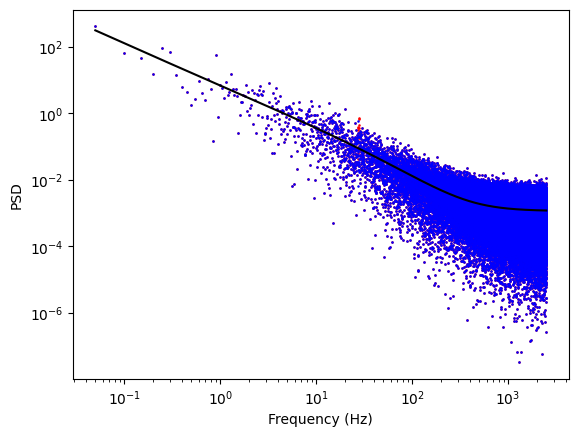

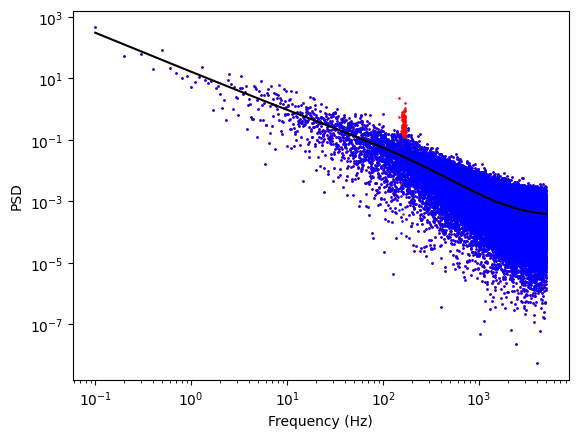

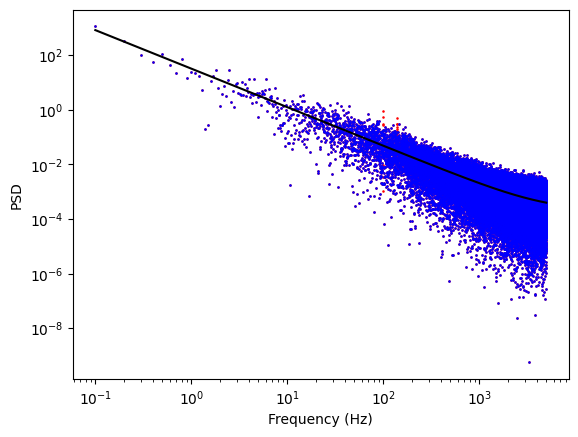

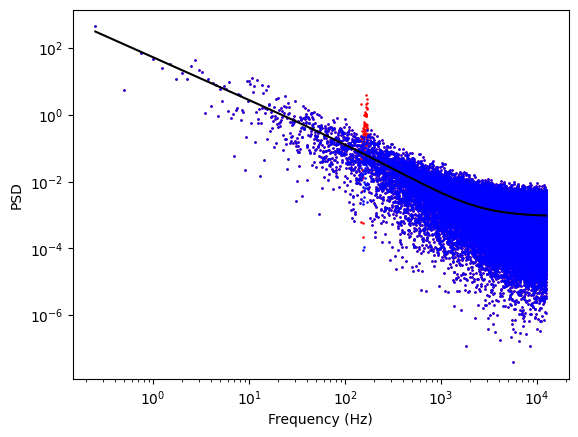

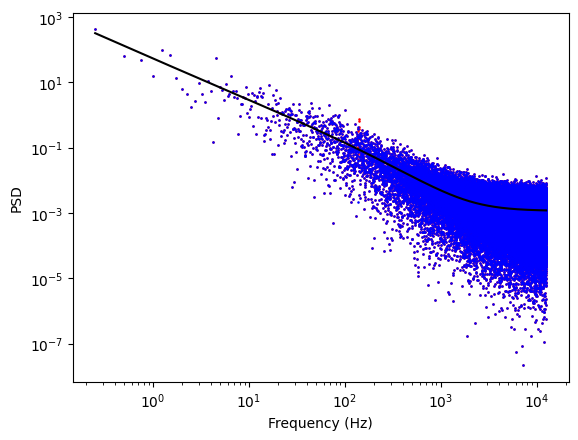

In [10]:
for data in data_list:
    frequencies = data.frequencies
    PSD = data.PSD
    plt.scatter(frequencies, PSD, s=.7,c='r')
    plt.scatter(frequencies, data.reconstructed_PSD, c='b', s=.7)
    plt.plot(frequencies, data.fit_function(frequencies, data.fit_params), c='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.show()

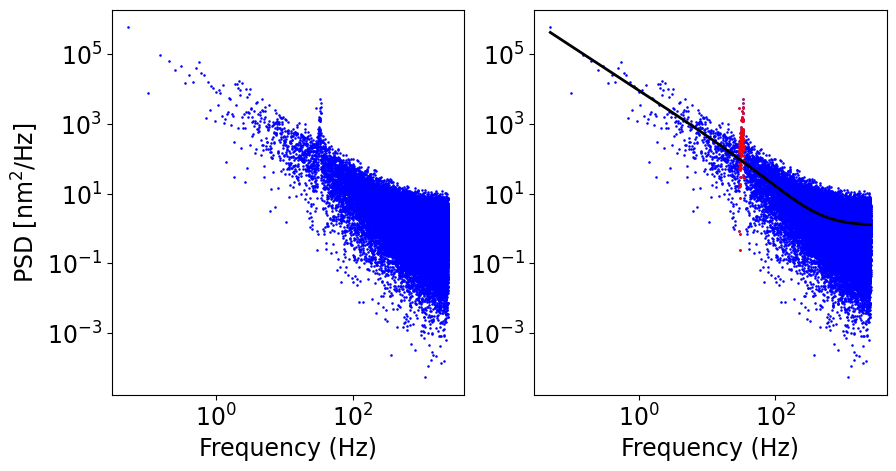

In [23]:
from SpectralMechanicsAnalysis.analyze_data import get_peak_indices, powerspectrum
nm_pro_pixel = (0.036768956332537246 * 1000)**2

my_data = data_list[2]
peak_indces = get_peak_indices(my_data.peaks)

frequencies = my_data.frequencies
PSD = my_data.PSD
dt =  my_data.t[1]-my_data.t[0]
plt.rcParams.update({'font.size': 17})
#two plots from left to right. The first one is the original PSD, the second one, the peak is plotted in red
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(frequencies, PSD*nm_pro_pixel, s=.7,c='blue')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("PSD [nm$^2$/Hz]")

ax2.scatter(frequencies, PSD*nm_pro_pixel, s=.7,c='blue')
ax2.scatter(frequencies[peak_indces], PSD[peak_indces]*nm_pro_pixel, s=.7,c='red')
ax2.plot(frequencies, my_data.fit_function(frequencies, my_data.fit_params)*nm_pro_pixel, c='black', linewidth=2.0)
#ax2.plot(frequencies, np.ones_like(frequencies)*(x_msd[0]/5)**2, c='green', linewidth=2.0)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency (Hz)")
#ax2.set_ylabel("PSD")


plt.savefig(r'C:\Users\jschulz\Desktop\psd_plots.svg', format='svg')

In [55]:
noise = np.sqrt(np.mean(PSD[-100:]/dt))

In [56]:
size_of_a_pixel = 0.036768956332537246

In [57]:
noise

0.028620242052117644

In [44]:
noise*size_of_a_pixel*1000

1.05233643024096

In [15]:
def compute_msd(x, dt):
    """
    Compute the mean squared displacement (MSD) of a 1D trajectory.
    
    Parameters:
    - x: numpy array of positions (e.g., in meters)
    - dt: sampling interval in seconds
    
    Returns:
    - A tuple of two numpy arrays:
        - lag_times: array of lag times (in seconds)
        - msd: array of MSD values at each lag time
    """
    n = len(x)
    lag_times = np.arange(1, n) * dt
    msd = np.zeros(n-1)
    
    for tau in range(1, n):
        differences = x[tau:] - x[:-tau]
        squared_differences = differences ** 2
        msd[tau-1] = squared_differences.mean()
    
    return lag_times, msd
t_msd, x_msd = compute_msd(my_data.reconstructed_x, my_data.t[1]-my_data.t[0])

In [16]:
x_msd[1]**2

5.673148403938467e-06

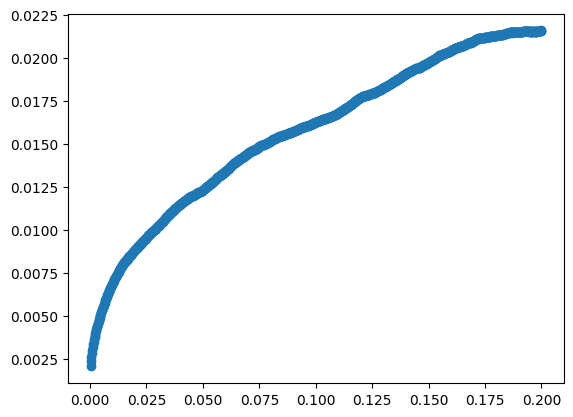

In [20]:
n_plot = 1000
plt.scatter(t_msd[:n_plot], x_msd[:n_plot])


In [116]:
dt = 1/1000
N_sample = int(10/dt)
x_gauss = np.random.normal(0, 1, N_sample)
Pxx_gauss =  np.abs(np.fft.fft(x_gauss)[:int(N_sample//2)])**2/N_sample*dt
print(np.mean(Pxx_gauss))
print(np.log10(np.mean(Pxx_gauss)))


0.0009977428300462898
-3.0009813844484947


In [72]:
np.mean(Pxx_gauss)

0.10530307065166893

ValueError: x and y must be the same size

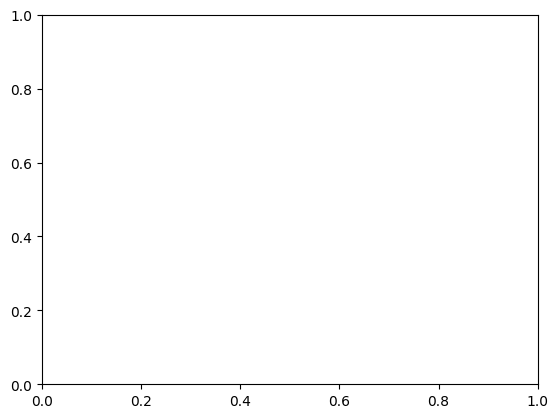

In [66]:
plt.scatter(f_gauss, Pxx_gauss, s=.7,c='blue')
#plt.xscale('log')
plt.yscale('log')

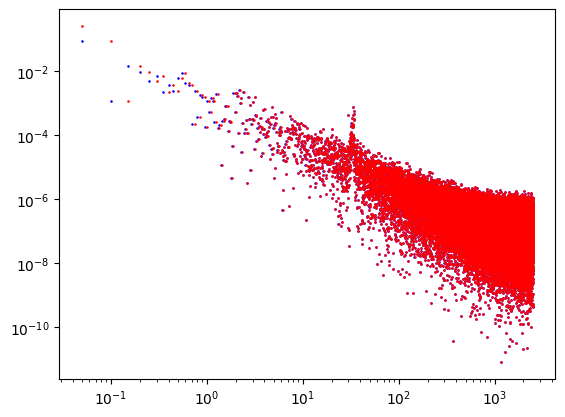

In [40]:
my_x = my_data.x
dt = 1/5000
len_x = len(my_x)
my_PSD = np.abs(np.fft.fft(my_x)[:int(len_x//2)])**2/len_x*dt
plt.scatter(frequencies, PSD, s=.7,c='blue')
plt.scatter(frequencies, my_PSD, s=.7,c='red')
plt.xscale('log')
plt.yscale('log')

In [34]:
frequencies[-1]

2499.975

In [81]:
print(len(my_data.x))
print(len(my_data.reconstructed_x))

my_mbr = mean_back_realxation(dt, my_data.reconstructed_x,Tau,T_MBR)
my_raw_mbr = mean_back_realxation(dt, my_data.x,Tau,T_MBR)

100000
100000


100%|██████████| 31804/31804 [00:00<00:00, 212291.07it/s]


In [89]:
mbr_trajectories = []
mbr_times = []
raw_mbr_trajectories = []
T_MBR = 0.05
titles = []

for data in data_list:
    dt = data.t[1] - data.t[0]
    Tau =  dt #* round(1/dt/1000)
    f_in_khz = round(1/dt/1000)

    mbr = mean_back_realxation(dt, data.reconstructed_x,Tau,T_MBR)
    mbr_trajectories.append(mbr)
    raw_mbr = mean_back_realxation(dt, data.x,Tau,T_MBR)
    raw_mbr_trajectories.append(raw_mbr)
    t_mbr = np.arange(0, len(mbr)*dt, dt)
    mbr_times.append(t_mbr)
    titles.append(f"{f_in_khz} khz")



100%|██████████| 31121/31121 [00:00<00:00, 206188.51it/s]


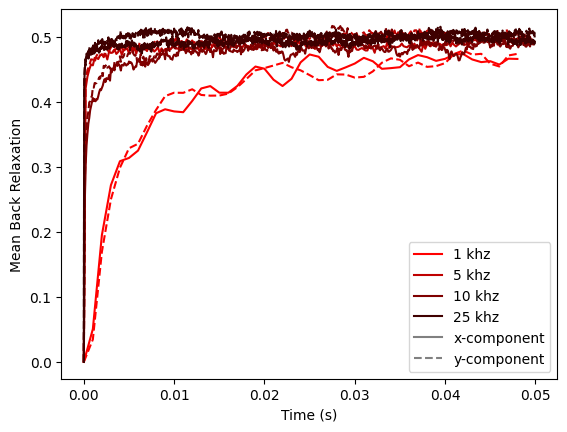

In [94]:
x_data_linestyle = '-'
y_data_linestyle = '--'
colors = ['#ff0000', '#bf0000', '#7f0000', '#3f0000']
for i,(t, mbr, title) in enumerate(zip(mbr_times, mbr_trajectories, titles)):
    if i%2 == 0:
        plt.plot(t, mbr, label=title, linestyle=x_data_linestyle, color=colors[i//2])
    else:
        plt.plot(t, mbr, linestyle=y_data_linestyle, color=colors[i//2])
plt.plot([],[], label="x-component", linestyle=x_data_linestyle, color='grey')
plt.plot([],[], label="y-component", linestyle=y_data_linestyle, color='grey')
plt.xlabel("Time (s)")
plt.ylabel("Mean Back Relaxation")
plt.legend()

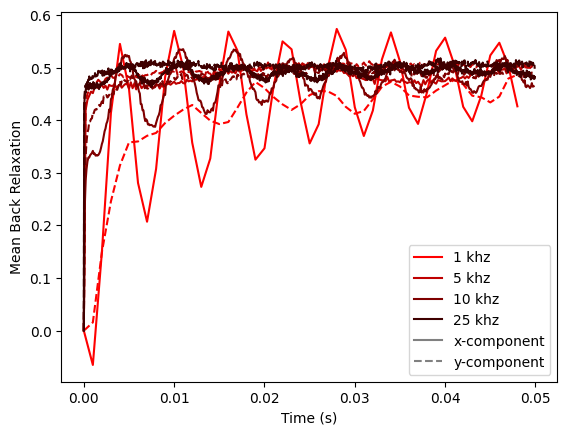

In [95]:
x_data_linestyle = '-'
y_data_linestyle = '--'
colors = ['#ff0000', '#bf0000', '#7f0000', '#3f0000']
for i,(t, mbr, title) in enumerate(zip(mbr_times, raw_mbr_trajectories, titles)):
    if i%2 == 0:
        plt.plot(t, mbr, label=title, linestyle=x_data_linestyle, color=colors[i//2])
    else:
        plt.plot(t, mbr, linestyle=y_data_linestyle, color=colors[i//2])
plt.plot([],[], label="x-component", linestyle=x_data_linestyle, color='grey')
plt.plot([],[], label="y-component", linestyle=y_data_linestyle, color='grey')
plt.xlabel("Time (s)")
plt.ylabel("Mean Back Relaxation")
plt.legend()

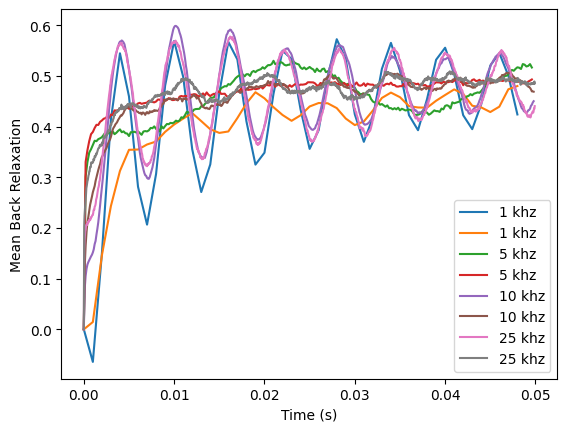

In [86]:
for t, mbr, title in zip(mbr_times, raw_mbr_trajectories, titles):
    plt.plot(t, mbr, label=title)
plt.xlabel("Time (s)")
plt.ylabel("Mean Back Relaxation")
plt.legend()